# IANNWTF - Homework 10
(by Group 17 - Nils Niehaus, Marlon Dammann, Philipp Bauer)
## Imports

In [112]:
import os
import re
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow_text import RegexSplitter

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as CosineDistance

## Dataset

In [2]:
try:
    import google.colab
    from google.colab import drive
    os.chdir('drive/MyDrive')
    with open('./bible.txt','r') as file:
        raw_text = file.read()
except:
    with open('./bible.txt','r') as file:
        raw_text = file.read()
raw_text[0:100]

'The First Book of Moses:  Called Genesis\n\n\n1:1 In the beginning God created the heaven and the earth'

In the following we will use only regex modifications and string class methods since the bible is, compared to other data, relatively easy to preprocess.

## Word Embeddings
### Preprocessing

In [3]:
preprocessed_text = raw_text.lower()
preprocessed_text = re.sub(r'(\n)|([0123456789:;,\.?!\)\(\"\']+)',"",preprocessed_text) # Replaces all unusual characters with a space

In [4]:
text_splitter = RegexSplitter(r' ')
word_split = text_splitter.split(preprocessed_text)
word_split[0][:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'the', b'first', b'book', b'of', b'moses', b'called', b'genesis',
       b'in', b'the', b'beginning'], dtype=object)>

In [5]:
def get_n_frequent(n,word_split):
    c = Counter(word_split)
    return [word for word,count in c.most_common(n)], [count for word,count in c.most_common(n)]

In [6]:
subset = 10000
tokens, frequencies = get_n_frequent(subset,word_split[0].numpy())
frequencies = [freq/int(word_split[0].shape[0]) for freq in frequencies]
print('Selected the',len(tokens),'most common words.')
print(tokens[:10])
print(frequencies[:10])

Selected the 10000 most common words.
[b'the', b'and', b'of', b'to', b'in', b'that', b'he', b'shall', b'i', b'for']
[0.07510630543068886, 0.06263178498629841, 0.04165822972772311, 0.01626236855249126, 0.015378177351206146, 0.015239136597416271, 0.012775550425896677, 0.011533633013404609, 0.011112461021342081, 0.010947771973163784]


In [7]:
def word2idx(words):
    return {words[i] : i for i in range(len(words))}
word2idx = word2idx(tokens)

In [8]:
def get_word_context_pairs(tokens,word_split,window=4):
    context_pairs = {token : [] for token in tokens}
    for token in tqdm(tokens,desc='Retrieving context words for tokens:'):
        context_words = []
        for i in range(len(word_split)):
            if word_split[i] == token:
                for s in range(window):
                    try:
                        if word_split[i+s] in tokens:
                            context_words += [word_split[i+s]]
                    except IndexError:
                        pass
                    except Exception as e:
                        print(e)
        context_pairs[token] = list(set(context_words))
    return context_pairs

In [9]:
context_pairs = get_word_context_pairs(tokens,word_split[0].numpy())

Retrieving context words for tokens:: 100%|██████████████████████████████████████| 10000/10000 [09:41<00:00, 17.19it/s]


In [10]:
target_pairs = [[(token,target) for target in context_pairs[token]] for token in list(context_pairs.keys())]

In [11]:
target_pairs = [pair for sublst in target_pairs for pair in sublst]

In [12]:
target_pairs = [(word2idx[a],word2idx[b]) for a,b in target_pairs]

In [13]:
data_raw = tf.data.Dataset.from_tensor_slices(target_pairs)

In [31]:
def preprocess_dataset(data):
    data = data.map(lambda datum: (datum[0],datum[1]))
    '''We shuffle, take a batch size of 64 and prefetch 20 elements.'''
    data = data.shuffle(10000000)
    data = data.batch(64)
    data = data.map(lambda a, b: (a,tf.reshape(b,(-1,1))))
    data = data.prefetch(20)
    return data

In [154]:
dataset = data_raw.apply(preprocess_dataset)

### Model

In [155]:
class SkipGram(tf.keras.layers.Layer):
    def __init__(self, vocab_size=10000, embedding_size=64, activation=tf.nn.softmax,optimizer=tf.keras.optimizers.Adam(0.001)):
        super(SkipGram, self).__init__()
        
        self.optimizer = optimizer
        self.vocab = vocab_size
        self.embedding_size = embedding_size
        self.activation = activation
        self.build()

    def build(self,input_shapes=None):
        self.w = tf.Variable(tf.random.normal([self.vocab,self.embedding_size]))
        self.b = tf.Variable(tf.zeros([self.vocab]))
        self.embedding = tf.Variable(tf.random.uniform([self.vocab,self.embedding_size]))

    def call(self, word, target):
        embedding = tf.nn.embedding_lookup(self.embedding, word)
        nce_loss = tf.nn.nce_loss(weights=self.w, biases=self.b, inputs=embedding, labels=target, num_sampled=64, num_classes=self.vocab)
        
        return tf.reduce_mean(nce_loss)

### Training

In [156]:
'''Trace'''
epoch_loss = {}
test_words = [b'holy',b'god',b'wine',b'angel',b'devil',b'sin',b'commandments']
for word in test_words:
    print(f'{word} is part of subset: {word in tokens}')

'''Hyperparameters'''
epochs = 10
learning_rate = 0.001

'''Model'''
model = SkipGram(optimizer=tf.keras.optimizers.Adam(learning_rate))

b'holy' is part of subset: True
b'god' is part of subset: True
b'wine' is part of subset: True
b'angel' is part of subset: True
b'devil' is part of subset: True
b'sin' is part of subset: True
b'commandments' is part of subset: True


In [162]:
def nearest_words_print(model):
    global test_words
    global word2idx
    embedding = model.embedding.numpy()
    results = []
    for test_word in test_words:
        idx = word2idx[test_word]
        distances = []
        for i in range(len(embedding)):
            if idx != i:
                distances += [CosineDistance(embedding[i], embedding[idx])]
        closest = np.argmin(distances)
        results += [{idx : word for word, idx in word2idx.items()}[closest]]
    print('############################################################')
    for i in range(len(test_words)):
        print(f'Closest target for word: \'{test_words[i].decode("utf-8")}\' was \'{results[i].decode("utf-8")}\'.')
    print('############################################################')

In [163]:
def training_loop(dataset,model,epochs):
    global epoch_loss
    for i in range(epochs):
        epoch_loss[i] = []
        for datum in tqdm(dataset,desc='Current epoch: ' + str(i)):
            train_step(datum,model,i)
        epoch_loss[i] = np.mean(epoch_loss[i])
        nearest_words_print(model)

In [164]:
def train_step(data,model,i):
    global epoch_loss
    with tf.GradientTape() as tape:
        loss = model(data[0],data[1])
        epoch_loss[i] += [loss.numpy()]
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [165]:
training_loop(dataset,model,epochs)

Current epoch: 0: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was yonder.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 1: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.69it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was yonder.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 2: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was yonder.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 3: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 4: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 5: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.73it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 6: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.83it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 7: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 8: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.72it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


Current epoch: 9: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s]


############################################################
Closest target for word: holy was chased.
Closest target for word: god was wert.
Closest target for word: wine was wisdomand.
Closest target for word: angel was himself.
Closest target for word: devil was rooms.
Closest target for word: sin was freewoman.
Closest target for word: commandments was utmost.
############################################################


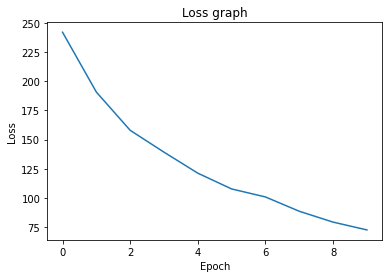

In [145]:
plt.plot(np.arange(0,epochs),[loss for loss in list(epoch_loss.values())])
plt.title('Loss graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()